In [1]:
import sys, os
sys.path.append('/cr/users/filip/bin/')

# from utils.Auger.SD import Monitoring

from scipy.optimize import curve_fit
from utils.binaries import *
from utils.plotting import *

def parabola(x, a, b, c):
    return a * x**2 + b*x + c

def make_histo_fit(x, y):

    sort_mask = np.argsort(x)
    x, y = x[sort_mask], y[sort_mask]   

    try:
        (a, b, c), pp = curve_fit(parabola, x, y, 
                            bounds=[[-np.inf, 0, 0],[0, np.inf, np.inf]],
                            sigma=np.sqrt(y),
                            p0=[-100, 1, 0],
                            check_finite=True)
    
    except ValueError:
        a, b, c, pp = np.nan, np.nan, np.nan, None

    return (a, b, c), pp

13:52:30 [INFO] utils          -- ( +2604ms) -- import logging
13:52:30 [INFO] utils.binaries -- (    +2ms) -- import numpy as np
13:52:30 [INFO] utils.binaries -- (    +6ms) -- import uncertainties
13:52:30 [INFO] utils.binaries -- (    +2ms) -- import numpy as np
13:52:30 [INFO] utils.binaries -- (    +6ms) -- import uncertainties
13:52:30 [INFO] utils.binaries -- (  +124ms) -- import pandas as pd
13:52:30 [INFO] utils.binaries -- (    +2ms) -- import binaries.tools as tools
13:52:30 [INFO] utils.plotting -- (  +485ms) -- import matplotlib.pyplot as plt
13:52:30 [INFO] utils.plotting -- (  +137ms) -- import seaborn as so
13:52:30 [DBUG] utils.plotting -- (    +6ms) -- font size set to 9.5
13:52:30 [DBUG] utils.plotting -- (    +2ms) -- label size set to 13.0
13:52:30 [DBUG] utils.plotting -- (    +0ms) -- figure size set to [6.6, 3.3]
13:52:30 [DBUG] utils.plotting -- (    +1ms) -- markersize set to 2.0
13:52:30 [DBUG] utils.plotting -- (    +1ms) -- usetex set to False
13:52:30 [INF

Nadia: -b/(2*a) = 49.5+/-3.0 ADC
NuriaJr: -b/(2*a) = 53.7+/-2.6 ADC


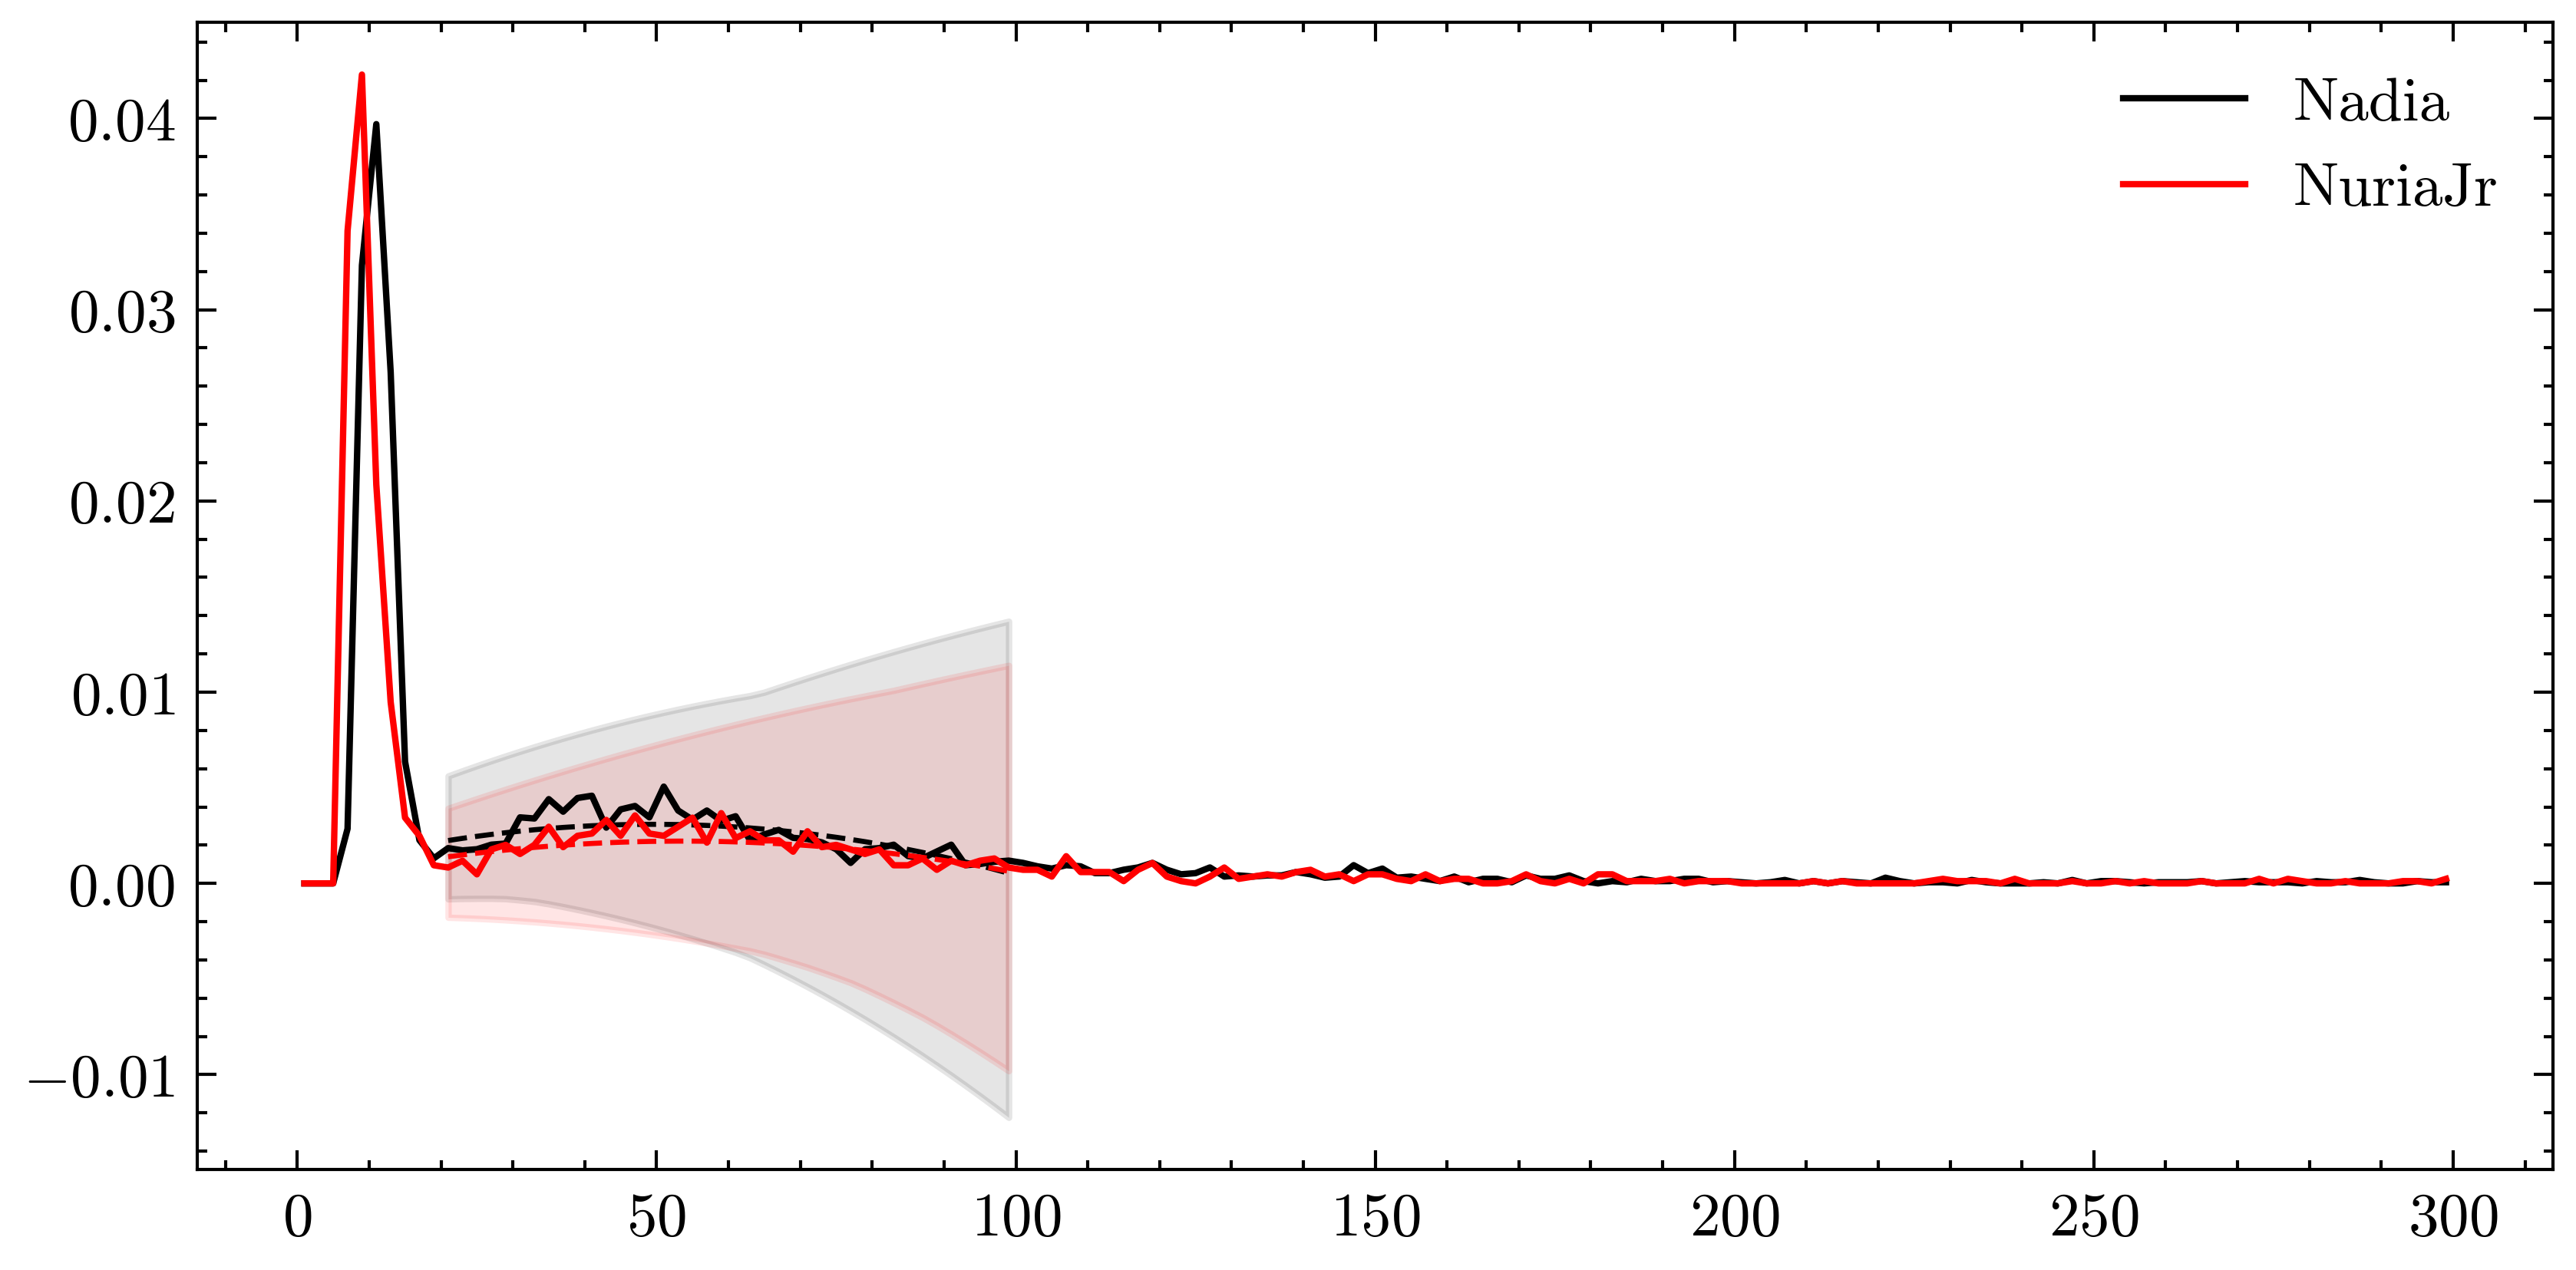

In [2]:
color = ['black', 'red']
n_files = [1433, 720]
mips, histos = [], []

for i, station in enumerate(["Nadia", "NuriaJr"]):

    peaks = np.loadtxt(f'/cr/users/filip/Data/SDMonitHistos/{station}_T1_coinc_histo.txt')
    counts, bins = np.histogram(peaks, bins=140, range=(20, 300))
    counts = counts / n_files[i] * 5000 * 2048 * 8.33e-9
    x_fit = (0.5 * (bins[1:] + bins[:-1]))[:40]
    popt, pcov = make_histo_fit(x_fit, counts[:40])
    err_up, err_down = tools.bootstrap_ci(parabola, popt, pcov, x_fit)

    n, all_bins = np.histogram(peaks, bins=150, range=(0, 300))
    plt.plot(0.5 * (all_bins[1:] + all_bins[:-1]), n / n_files[i] * 5000 * 2048 * 8.33e-9, c=color[i], label=station, ls='solid')
    plt.plot(x_fit, parabola(x_fit, *popt), ls='--', lw=0.8, c=color[i])
    plt.fill_between(x_fit, err_up, err_down, alpha=0.1, color=color[i])

    (a, b, c) = uncertainties.correlated_values(popt, pcov)
    mips.append(-b/(2*a))
    histos.append(peaks)

    print(f"{station}: {-b/(2*a) = :.1f} ADC")

plt.legend()

Text(0, 0.5, '$\\sigma_\\mathrm{stat.}\\,/\\,\\mathrm{MIP}_\\mathrm{Peak}$')

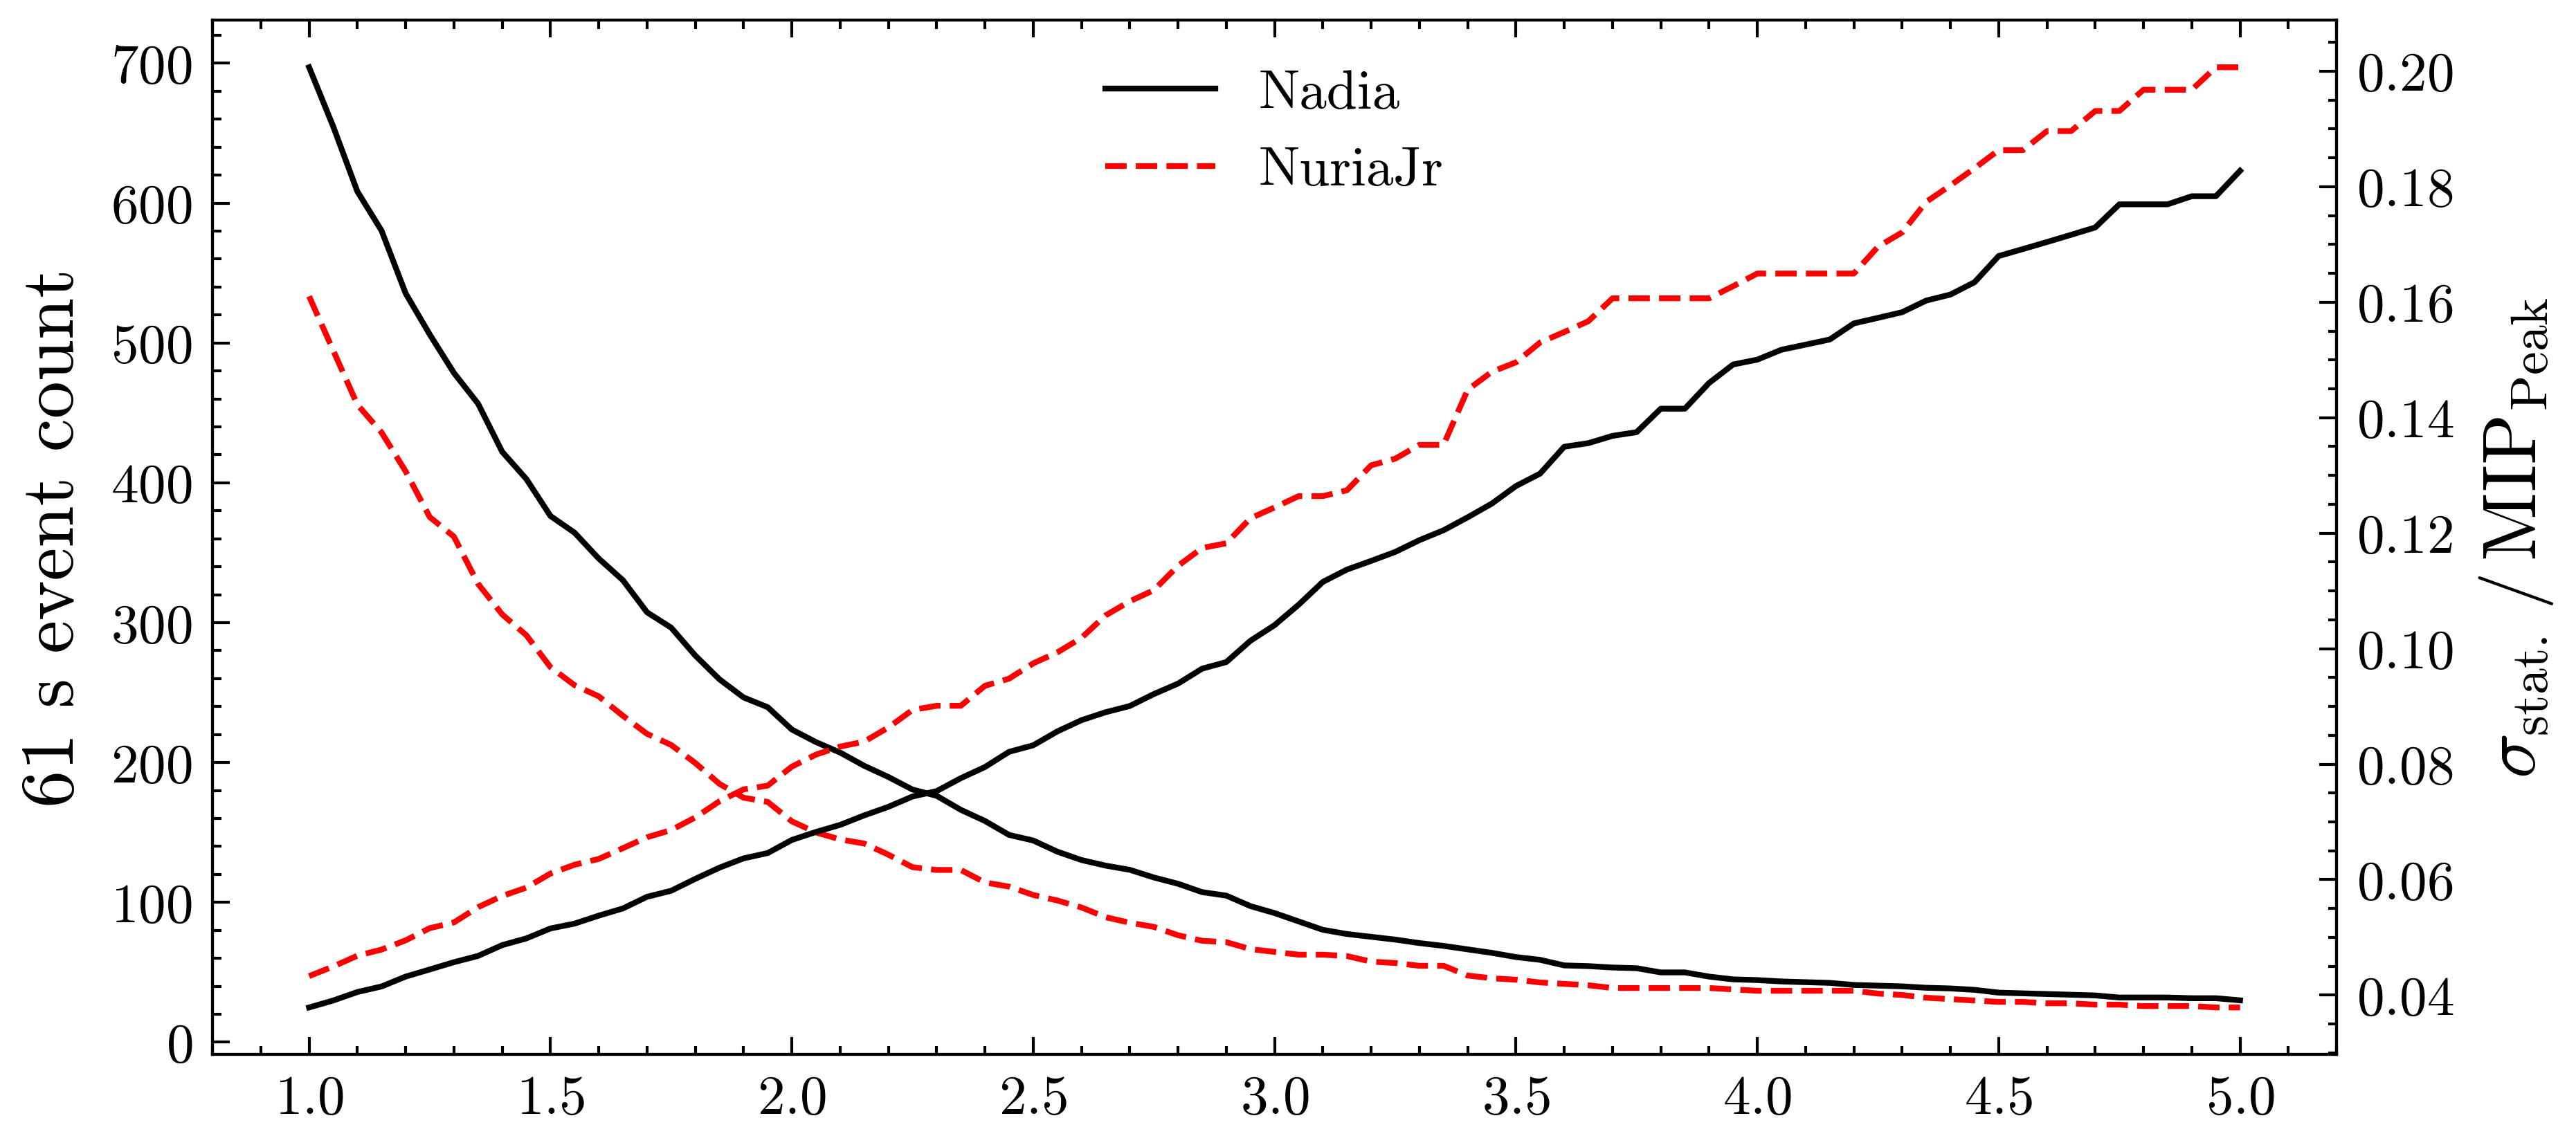

In [3]:
thresholds = np.arange(1.0, 5.01, 0.05)

ax1 = plt.gca()
ax2 = ax1.twinx()
for histo, mip, n_file in zip(histos, mips, n_files):

    event_counts, errors = [], []
    for t in thresholds:
        inclusive_rate = np.sum([c > t * mip.n for c in histo]) / (n_file * 5000 * 2048 * 8.33e-9)
        event_counts.append(61 * inclusive_rate)
        errors.append(1/np.sqrt(61 * inclusive_rate))

    ax1.plot(thresholds, event_counts)
    ax2.plot(thresholds, errors, label = 'Nadia' if n_file > 1000 else "NuriaJr")

ax2.legend(loc='upper center')
ax1.set_ylabel("61 s event count")
ax2.set_ylabel("$\sigma_\mathrm{stat.}\,/\,\mathrm{MIP}_\mathrm{Peak}$")

/tmp/ipykernel_2382211/1171060466.py:13: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(0.5 * (bins[1:] + bins[:-1]) / MIP[station], n_wcd / n_ssd, label=station)


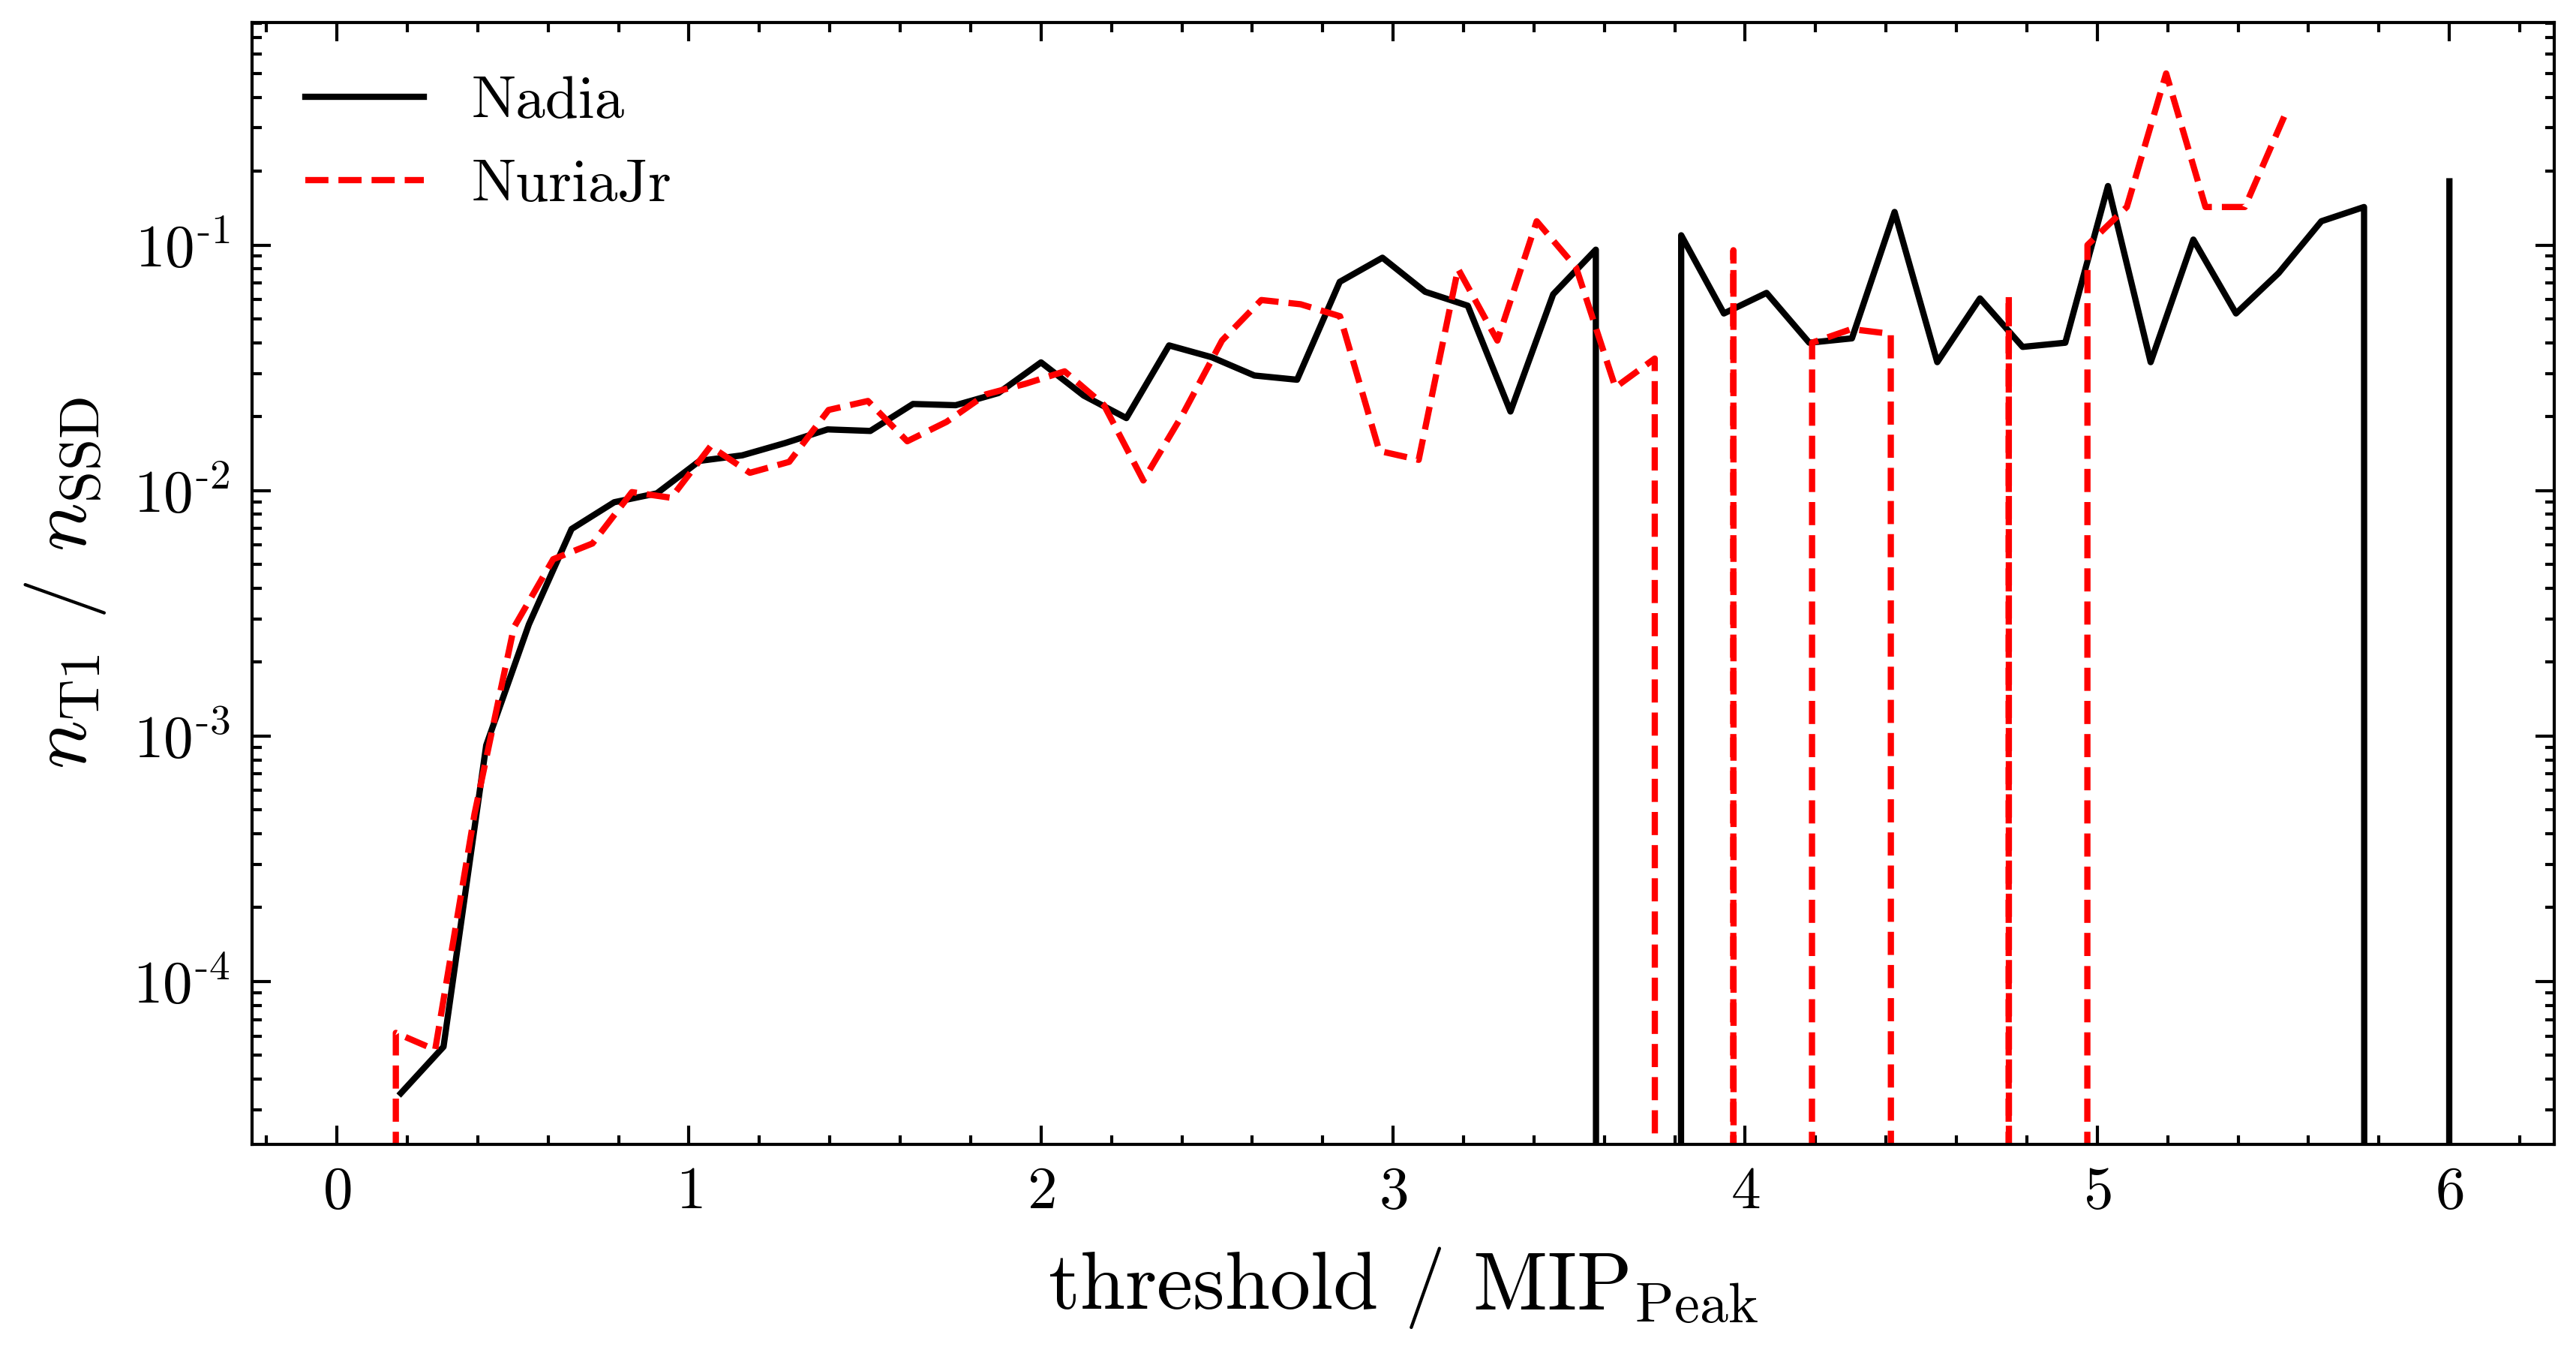

In [8]:
MIP = {'Nadia':             49.5,
       'NuriaJr':           53.7}

for station in ["Nadia", "NuriaJr"]:
    ssd_only = np.loadtxt(f'/cr/users/filip/Data/StationEfficiencies/{station}FilteredDownsampled_ssd_only.txt')
    ssd_and_t1 = np.loadtxt(f'/cr/users/filip/Data/StationEfficiencies/{station}FilteredDownsampled_ssd_and_t1.txt')



    n_ssd, bins = np.histogram(ssd_only, range=(0, 300), bins=50)
    n_wcd, bins = np.histogram(ssd_and_t1, range=(0, 300), bins=50)

    plt.plot(0.5 * (bins[1:] + bins[:-1]) / MIP[station], n_wcd / n_ssd, label=station)

plt.ylabel(r"$n_\mathrm{T1}$ / $n_\mathrm{SSD}$")
plt.xlabel("threshold / $\mathrm{MIP}_\mathrm{Peak}$")
plt.legend()
plt.yscale('log')